In [ ]:
import os
from typing import List, Tuple, Dict

import statistics
import pandas as pd
import plotly.express as px
from scipy.spatial import cKDTree

from typing import List, Tuple, Optional
import pyvista as pv
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

import numpy as np
from sklearn.decomposition import PCA, TruncatedSVD

import rasterio
from rasterio.plot import show

from sklearn.neighbors import NearestNeighbors
from numpy.linalg import svd

flag_col = 5

def mean_center_xy(original_points): 
    max_x, max_y, max_z = np.max(original_points[:, :3], axis=0)
    min_x, min_y, min_z = np.min(original_points[:, :3], axis=0)

    center_x = (max_x + min_x) / 2
    center_y = (max_y + min_y) / 2
    center_z = (max_z + min_z) / 2

    transformed_points = original_points.copy()

    transformed_points[:, 0] = transformed_points[:, 0] - center_x
    transformed_points[:, 1] = transformed_points[:, 1] - center_y
    transformed_points[:, 2] = transformed_points[:, 2] - center_z

    # TODO use only ground points for SVD, now data lacks classification attribute
    svd = TruncatedSVD(n_components=2)
    transformed_points[:,:2] = svd.fit_transform(transformed_points[:,:2])  # no centering here

    return transformed_points, original_points


def compute_cross_sectional_profile(triplets):
    values = [middle[2] - (left[2] + right[2]) / 2 for left, right, middle in triplets]
    return statistics.median(values), statistics.mean(values), statistics.stdev(values)

def compute_road_skeweness(triplets):
    values = [left[2] + right[2] for left, right, _ in triplets]
    return statistics.median(values), statistics.mean(values), statistics.stdev(values)


def compute_ditch_depths(ditch_profiles, triplets):
    left_edge_z = statistics.median([left[2] for left, _, _ in triplets])
    right_edge_z = statistics.median([right[2] for _, right, _ in triplets])

    ditch_profile_depths_left = []
    ditch_profile_depths_right = []

    for i in range(len(ditch_profiles[0]["left"])-1):
        if not (np.isnan(ditch_profiles[i]["left"][i]).any() or np.isnan(ditch_profiles[i]["right"][i]).any()):
            left_min_z = np.min(ditch_profiles[i]["left"][i])
            right_min_z = np.min(ditch_profiles[i]["right"][i])
            # print(left_min_z, right_min_z)

            ditch_profile_depths_left.append(triplets[i][0][2] - left_min_z)
            ditch_profile_depths_right.append(triplets[i][1][2] - right_min_z)

            # print(triplets[i][0][2], left_min_z)

    return np.median(ditch_profile_depths_right), np.median(ditch_profile_depths_left)

def compute_ditch_slopes(ditch_profiles):
    ditch_angles_left = []
    ditch_angles_right = []

    for i in range(len(ditch_profiles[0]["left"])-1):
        left_z = ditch_profiles[i]["left"][i]
        right_z = ditch_profiles[i]["right"][i]

        if not (np.isnan(left_z).any() or np.isnan(right_z).any()):
            left_z = left_z.astype(float)
            right_z = right_z.astype(float) 

            n_left = len(left_z)
            y = np.arange(0, n_left*0.3, 0.3)

            n_right = len(right_z)
            y = np.arange(0, n_right*0.3, 0.3)

            # Fit z = m*y + b (least squares)
            m_left, _b = np.polyfit(y, left_z, 1)
            m_right, _b = np.polyfit(y, right_z, 1)

            # Absolute angle of the slope (degrees)
            angle_deg_left = float(np.degrees(np.arctan(m_left)))
            angle_deg_right = float(np.degrees(np.arctan(m_right)))

            ditch_angles_left.append(angle_deg_left)
            ditch_angles_right.append(angle_deg_right)

    return np.median(ditch_angles_left), np.median(ditch_angles_right)

def fetch_road_triplets(
    pts: np.ndarray, flag_col: int,
    y_start: float = -1.6, y_stop: float = 1.6,
    y_step: float = 0.20, k: int = 1
) -> Tuple[float, list]:
    mask = pts[:, flag_col] == 0
    road_pts = pts[mask]
    if road_pts.size == 0:
        return np.nan, []

    xs, ys = road_pts[:, 0], road_pts[:, 1]
    widths = []
    triplets = []
    bin_edges = np.arange(y_start, y_stop, y_step)
    mid_points_idxs = []

    tree = cKDTree(road_pts[:, :2])

    for low in bin_edges:
        high = low + y_step
        in_bin = (ys >= low) & (ys < high)
        bin_pts = road_pts[in_bin]
        bin_xs = bin_pts[:, 0]

        if bin_pts.shape[0] < 2 * k:
            continue

        left_indices = np.argpartition(bin_xs, k - 1)[:k]
        right_indices = np.argpartition(-bin_xs, k - 1)[:k]

        left_pts = bin_pts[left_indices]
        right_pts = bin_pts[right_indices]

        # Sort by y-coordinate for consistent pairing
        left_pts = left_pts[np.argsort(left_pts[:, 1])]
        right_pts = right_pts[np.argsort(right_pts[:, 1])]

        left_med = np.median(left_pts[:, 0])
        right_med = np.median(right_pts[:, 0])

        # Choose a representative left and right point (median x-value closeness)
        left_med_idx = np.argmin(np.abs(left_pts[:, 0] - left_med))
        right_med_idx = np.argmin(np.abs(right_pts[:, 0] - right_med))

        left_pt = left_pts[left_med_idx]
        right_pt = right_pts[right_med_idx]

        # Find the midpoint and its closest road point
        midpoint = (left_pt + right_pt) / 2
        midpoint_xy = midpoint[:2]
        dist, idx = tree.query(midpoint_xy, k=1)
        mid_points_idxs.append(idx)
        middle_pt = road_pts[idx]

        # Store as a triplet (left, right, middle)
        triplets.append((left_pt, right_pt, middle_pt))

    return triplets, mid_points_idxs


def mls_to_als(mid_point, big_round=True):
    if big_round:
        translation = np.array([4.217286e+06, -5.329880e+06, -1.310565e+05])
        rotation = np.array([
            [ 7.465840e-01, -6.652710e-01,  5.179679e-03],
            [ 6.652199e-01,  7.463672e-01, -2.045683e-02],
            [ 9.743394e-03,  1.871837e-02,  9.997773e-01]
        ])
        rot_inv = rotation.T
        trans_inv = -rot_inv @ translation
        # print(f"mid point shape: {mid_point.shape}")
        # print(f"rot_inv shape: {rot_inv.shape}")
        # print(f"trans_inv shape: {trans_inv.shape}")
        points_als = (rot_inv @ mid_point).T + trans_inv
        return points_als

def fetch_middle_point_of_road(triplets):  
    mid_points = np.array([middle for _, _, middle in triplets])
    median_mid_point = np.median(mid_points, axis=0)
    median_mid_point = mls_to_als(median_mid_point[:3], big_round=True).flatten()
    
    return median_mid_point


def ditch_profiles_from_triplets(
    pts: np.ndarray,
    triplets: List[Tuple[np.ndarray, np.ndarray, np.ndarray]],
    flag_col: Optional[int] = None,          # if provided, rows with flag==0 are treated as "road" and excluded
    y_start: float = -1.6, y_stop: float = 1.6, y_step: float = 0.20,  # SAME y-bins as your road binning
    x_width: float = 2.2,                    # ditch width from road edge
    x_step: float = 0.30                     # x_bin size
) -> Tuple[np.ndarray, np.ndarray, List[Dict[str, np.ndarray]]]:

    if flag_col is not None:
        ditch_pts = pts[pts[:, flag_col] != 0]
    else:
        ditch_pts = pts

    if ditch_pts.size == 0 or len(triplets) == 0:
        y_bin_edges = np.arange(y_start, y_stop, y_step)
        x_bin_edges = np.arange(0.0, x_width, x_step)
        return y_bin_edges, x_bin_edges, []

    X = ditch_pts[:, 0]
    Y = ditch_pts[:, 1]
    Z = ditch_pts[:, 2]

    # Bins
    y_bin_edges = np.arange(y_start, y_stop, y_step)
    n_y_bins = len(y_bin_edges)
    x_bin_edges = np.arange(0.0, x_width, x_step)
    n_x_bins = len(x_bin_edges)

    profiles: List[Dict[str, np.ndarray]] = []

    def fill_row_for_side(edge_x: float, yi: int, side: str) -> np.ndarray:
        grid = np.full((n_y_bins, n_x_bins), np.nan, dtype=float)

        # Select points in this y-bin row
        y_low = y_start + yi * y_step
        y_high = y_low + y_step
        in_row = (Y >= y_low) & (Y < y_high)
        if not np.any(in_row):
            return grid

        Xr = X[in_row]
        Zr = Z[in_row]

        if side == "left":
            in_side = (Xr <= edge_x) & (Xr >= edge_x - x_width)
            x_off = edge_x - Xr[in_side] 
        else:  # "right"
            in_side = (Xr >= edge_x) & (Xr <= edge_x + x_width)
            x_off = Xr[in_side] - edge_x  

        if not np.any(in_side):
            return grid

        Zs = Zr[in_side]
        x_idx = np.floor(x_off / x_step).astype(int)
        valid = (x_idx >= 0) & (x_idx < n_x_bins)
        if not np.any(valid):
            return grid

        x_idx = x_idx[valid]
        Zs = Zs[valid]

        order = np.argsort(x_idx)
        x_idx = x_idx[order]
        Zs = Zs[order]

        start = 0
        while start < x_idx.size:
            end = start + 1
            while end < x_idx.size and x_idx[end] == x_idx[start]:
                end += 1
            xi = int(x_idx[start])
            grid[yi, xi] = np.nanmin(Zs[start:end])
            start = end

        return grid

    for (left_pt, right_pt, middle_pt) in triplets:
        y_val = float(middle_pt[1])
        yi = int(np.floor((y_val - y_start) / y_step))
        if yi < 0 or yi >= n_y_bins:
            profiles.append({"left": np.full((n_y_bins, n_x_bins), np.nan),
                             "right": np.full((n_y_bins, n_x_bins), np.nan)})
            continue

        lx = float(left_pt[0])
        rx = float(right_pt[0])

        left_grid  = fill_row_for_side(lx, yi, "left")
        right_grid = fill_row_for_side(rx, yi, "right")

        profiles.append({"left": left_grid, "right": right_grid})

    return y_bin_edges, x_bin_edges, profiles

def compute_slope(pts: np.ndarray) -> float:
    y = pts[:, 1].astype(float)
    z = pts[:, 2].astype(float)

    # Fit z = m*y + b (least squares)
    m, _b = np.polyfit(y, z, 1)

    # Absolute angle of the slope (degrees)
    angle_deg = float(np.degrees(np.arctan(m)))
    return abs(angle_deg)

def compute_width(triplets: np.array):
    widths = [right[0] - left[0] for left, right, _ in triplets]
    return statistics.median(widths)

def compute_average_intensity_value_for_road(points):
    road_points = points[points[:,flag_col] == 0]
    return np.mean(road_points[:,3]), np.std(road_points[:,3])

def get_high_veg_points_above_road(triplets: np.array, all_points: np.array):
    median_right_edge_x = np.median([r[0] for _, r, _ in triplets])
    median_left_edge_x = np.median([l[0] for l, _, _ in triplets])

    hv = all_points[all_points[:, 5] == 1]
    if median_left_edge_x < median_right_edge_x:
        hv = hv[(hv[:, 0] > median_left_edge_x) & (hv[:, 0] < median_right_edge_x)]
  
    return hv

def compute_stand_height(triplets: np.array, all_points: np.array):
    median_right_edge_x = np.median([r[0] for _, r, _ in triplets])
    median_left_edge_x = np.median([l[0] for l, _, _ in triplets])
    
    median_right_edge_z = np.median([r[2] for _, r, _ in triplets])
    median_left_edge_z = np.median([l[2] for l, _, _ in triplets])
    
    right_side_points = all_points[all_points[:, 0] > median_right_edge_x]
    left_side_points = all_points[all_points[:, 0] < median_left_edge_x]
    
    right_highest = np.sort(right_side_points[:, 2])[-50:] 
    left_highest = np.sort(left_side_points[:, 2])[-50:] 
    
    median_right_highest = np.median(right_highest) if len(right_highest) > 0 else np.nan
    median_left_highest = np.median(left_highest) if len(left_highest) > 0 else np.nan
    
    stand_height_right = median_right_highest - median_right_edge_z if not np.isnan(median_right_highest) else np.nan
    stand_height_left = median_left_highest - median_left_edge_z if not np.isnan(median_left_highest) else np.nan
    
    return stand_height_left, stand_height_right

def cov_3x3(neigh_pts):
    c = neigh_pts.mean(axis=0, keepdims=True)
    X = neigh_pts - c
    M = X.shape[0]
    if M <= 1:
        return None
    return (X.T @ X) / (M - 1)

def compute_road_surface_roughness(points: np.ndarray):
    road_points = points[points[:,flag_col] == 0][:,:3] 

    nbrs = NearestNeighbors(n_neighbors=16, algorithm='auto').fit(road_points)
    dist, indices = nbrs.kneighbors(road_points)

    surface_variation = np.zeros(len(indices)) 

    for k, ind in enumerate(indices):
        neigh_pts = road_points[ind,:] 
        cov = cov_3x3(neigh_pts)
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        surface_variation[k] = eigenvalues[0] / eigenvalues.sum()

    return np.mean(surface_variation), np.std(surface_variation)


def fetch_depth_to_water_value(x, y):
    # TODO find correct tif file based on x,y location
    tif_path1 = r"C:\Users\telukkari\Downloads\paituli_68626932\luke\dtw\2023\DTW_INT_CMv2_4\M4134F.tif"
    tif_path2 = r"C:\Users\telukkari\Downloads\paituli_68626932\luke\dtw\2023\DTW_INT_CMv2_4\M4134H.tif"
    tif_path3 = r"C:\Users\telukkari\Downloads\paituli_68626932\luke\dtw\2023\DTW_INT_CMv2_4\M4143E.tif"
    tif_path4 = r"C:\Users\telukkari\Downloads\paituli_68626932\luke\dtw\2023\DTW_INT_CMv2_4\M4143G.tif"

    with rasterio.open(tif_path4) as src:
        row, col = src.index(x, y)
        band1 = src.read(1)
        value = band1[row, col]

    return value

In [ ]:
import laspy

# folder = '/home/teemulukkari/Pointcept/pointcept/models/point_transformer_v3/visualizations/predictions_numpy'
# npy_files = sorted(glob.glob(os.path.join(folder, "*.npy")))

path = r"C:\Users\telukkari\Documents\Python\forest_road_network_analysis\data\deep_learning_preds\preds_numpy\segment_1833_pred.npy" # 1841 # 1228
# path_full_cloud = r"D:\Data\MLS_EVO\numpy_files\original\plot2_vegetation_part_road_vegetation_npy\segment_1841.npy"
path = r"C:\Users\telukkari\Documents\Python\forest_road_bearing_capacity\data\deep_learning_preds\lieksa_preds\kiimasuo\avg_predictions_segment_10.las"
las = laspy.read(path)
data = np.vstack((las.x, las.y, las.z, las.intensity, las.avg_prediction)).T


data = np.load(path)
# data = np.load(path_full_cloud)

# print(data.shape)
# print(data.shape)

transformed_points, original_points = mean_center_xy(data)
triplets, mid_points_idxs = fetch_road_triplets(transformed_points, flag_col=flag_col)
# print(triplets)
y_bin_edges, x_bin_edges, ditch_profiles = ditch_profiles_from_triplets(triplets=triplets, pts=transformed_points, flag_col=flag_col)


ditch_slope_left, ditch_slope_right = compute_ditch_slopes(ditch_profiles)

print(ditch_slope_left, ditch_slope_right)

-0.7047879331737965 3.610322663247683


In [20]:
import numpy as np
import pyvista as pv

def visualize_with_pyvista(
    pts: np.ndarray,
    triplets,
    ditch,                       # either (y_edges, x_edges, profiles) OR just profiles (list)
    on_road_veg_height,
    number_of_on_road_veg_points,
    high_veg_points_above_road,
    stand_height_left,
    stand_height_right,
    depth_to_water,
    mean_road_surface_variation,
    std_road_surface_variation,
    width,
    slope,
    cross_sectional_profile,
    right_ditch_depth,
    left_ditch_depth,
    ditch_slope_right,
    ditch_slope_left,
    average_intensity_value_for_road,
    std_intensity_value_for_road,
    y_edges: np.ndarray = None,  # required if 'ditch' is just a profiles list
    x_edges: np.ndarray = None,  # required if 'ditch' is just a profiles list
    cloud_point_size: float = 4.0,
    triplet_point_size: float = 5.0,
    ditch_point_size: float = 5.0,
    road_point_size: float = 4.0,
    view_xy: bool = False,
):
    if isinstance(ditch, (tuple, list)) and len(ditch) == 3 and isinstance(ditch[0], np.ndarray):
        y_edges, x_edges, profiles = ditch
    else:
        profiles = ditch
        if y_edges is None or x_edges is None:
            raise ValueError()

    cloud_xyz = pts[:, :3]
    cloud = pv.PolyData(cloud_xyz)

    road_mask = pts[:, flag_col] == 0
    on_road_veg_mask = pts[:, flag_col] == 2
    road_pd = pv.PolyData(pts[road_mask, :3])
    on_road_veg_pd = pv.PolyData(pts[on_road_veg_mask, :3])

    triplet_pd = None
    if len(triplets) > 0:
        triplet_xyz = np.vstack([np.vstack([l[:3], r[:3], m[:3]]) for (l, r, m) in triplets])
        triplet_pd = pv.PolyData(triplet_xyz)

    y_step = (y_edges[1] - y_edges[0]) if len(y_edges) > 1 else 0.10
    x_step = (x_edges[1] - x_edges[0]) if len(x_edges) > 1 else 0.10
    y_centers = y_edges + 0.5 * y_step
    x_centers = x_edges + 0.5 * x_step

    ditch_points_all = []
    line_cells = []  
    current_idx = 0

    def add_profile_line(x_vals, y_vals, z_vals):
        nonlocal current_idx
        order = np.argsort(x_vals)
        pts_profile = np.column_stack([x_vals[order], y_vals[order], z_vals[order]])
        n = len(pts_profile)
        if n < 2:
            return
        ditch_points_all.append(pts_profile)
        line = np.hstack(([n], np.arange(current_idx, current_idx+n)))
        line_cells.append(line)
        current_idx += n

    for i, (lpt, rpt, _mpt) in enumerate(triplets):
        if i >= len(profiles):
            break
        grids = profiles[i]
        left_grid  = grids.get("left")
        right_grid = grids.get("right")

        # LEFT side
        if left_grid is not None and left_grid.size > 0:
            mask = ~np.isnan(left_grid)
            if np.any(mask):
                yi, xi = np.where(mask)
                y_vals = y_centers[yi]
                x_off  = x_centers[xi]
                x_vals = float(lpt[0]) - x_off
                z_vals = left_grid[mask]
                add_profile_line(x_vals, y_vals, z_vals)

        # RIGHT side
        if right_grid is not None and right_grid.size > 0:
            mask = ~np.isnan(right_grid)
            if np.any(mask):
                yi, xi = np.where(mask)
                y_vals = y_centers[yi]
                x_off  = x_centers[xi]
                x_vals = float(rpt[0]) + x_off
                z_vals = right_grid[mask]
                add_profile_line(x_vals, y_vals, z_vals)

    ditch_pd = None
    if ditch_points_all:
        all_points = np.vstack(ditch_points_all)
        cells = np.hstack(line_cells).astype(int)
        ditch_pd = pv.PolyData(all_points, lines=cells)

    p = pv.Plotter()
    p.set_background("black")

    p.add_mesh(cloud, color="gray", render_points_as_spheres=True, point_size=cloud_point_size)

    if triplet_pd is not None:
        p.add_mesh(triplet_pd, color="white", render_points_as_spheres=True, point_size=triplet_point_size)

    if ditch_pd is not None:
        p.add_mesh(ditch_pd, color="orange", line_width=2)
        p.add_mesh(ditch_pd, color="orange", render_points_as_spheres=True, point_size=ditch_point_size)

    if high_veg_points_above_road is not None:
        high_veg_pd = pv.PolyData(high_veg_points_above_road[:,:3])
        p.add_mesh(high_veg_pd, color="green", render_points_as_spheres=True, point_size=cloud_point_size)

    p.add_mesh(road_pd, color="brown", render_points_as_spheres=True, point_size=road_point_size)

    if on_road_veg_mask.sum() > 0:
        p.add_mesh(on_road_veg_pd, color="lime", render_points_as_spheres=True, point_size=road_point_size)

    legend_entries = []

    legend_entries.append((f"Longitudinal slope: {slope:.2f}°", "white"))
    legend_entries.append((f"Estimated road width: {width:.2f} m", "white"))
    legend_entries.append((f"Cross-sectional profile: {cross_sectional_profile:.2f} m", "white"))

    legend_entries.append((f"Ditch depth (right): {right_ditch_depth:.2f} m", "white"))
    legend_entries.append((f"Ditch depth (left): {left_ditch_depth:.2f} m", "white"))
    legend_entries.append((f"Ditch slope (left): {ditch_slope_left:.2f}°", "white"))
    legend_entries.append((f"Ditch slope (right): {ditch_slope_right:.2f}°", "white"))
    legend_entries.append((f"Stand height of on-road veg.: {on_road_veg_height:.2f} m", "white"))
    legend_entries.append((f"Number of on-road veg. points: {number_of_on_road_veg_points:.2f}", "white"))
    # legend_entries.append((f"Number of high veg. points above road: {high_veg_points_above_road.shape[0]}", "white"))
    legend_entries.append((f"Stand height (left): {stand_height_left:.2f} m", "white"))
    legend_entries.append((f"Stand height (right): {stand_height_right:.2f} m", "white"))
    legend_entries.append((f"Road surface variation: mean {mean_road_surface_variation:.4f}, std: {std_road_surface_variation:.4f}", "white"))
    legend_entries.append((f"Road intensity: mean {average_intensity_value_for_road:.4f}, std: {std_intensity_value_for_road:.4f}", "white"))

    # legend_entries.append((f"Topographic wetness index: ", "white"))
    # legend_entries.append((f"Depth to water (2x2 m resolution, LUKE 2023): {depth_to_water:.2f} cm", "white"))

    legend = p.add_legend(legend_entries, size=(0.5, 0.5))

    p.show()

# ON-ROAD VEGETATION STATS
on_road_veg = original_points[original_points[:, flag_col] == 2]
number_of_on_road_veg_points = on_road_veg.shape[0]

top10_idx = np.argsort(on_road_veg[:, 2])[-10:][::-1]
highest_on_road_veg = on_road_veg[top10_idx]

median_road_z = np.median(original_points[original_points[:, flag_col] == 0][:, 2])
on_road_veg_height = np.median(highest_on_road_veg[:, 2]) - median_road_z

# DATA CENTERING
transformed_points, original_points = mean_center_xy(data)

# ROAD TRIPLET AND DITCH PROFILES
triplets, mid_points_idxs = fetch_road_triplets(transformed_points, flag_col=flag_col)
y_bin_edges, x_bin_edges, ditch_profiles = ditch_profiles_from_triplets(
    triplets=triplets, pts=transformed_points, flag_col=flag_col
)
right_ditch_depth, left_ditch_depth = compute_ditch_depths(ditch_profiles, triplets)

# ABOVE ROAD HIGH VEGETATION STATS
# high_veg_points_above_road = get_high_veg_points_above_road(triplets, transformed_points)

stand_height_left, stand_height_right = compute_stand_height(triplets, transformed_points)

# FETCH DEPTH TO WATER VALUE FROM LUKE MAP
middle_point = fetch_middle_point_of_road(triplets)

depth_to_water = fetch_depth_to_water_value(middle_point[0], middle_point[1])

# MODEL ROAD AREA SHADINESS BASED ON TREES, ROAD DIRECTION, SUN ANGLE
shadiness = 0 # TODO

# FETCH SOIL TYPE FROM SOIL TYPE MAP
soil_type = 0 # TODO

# SURFACE VARIATION
mean_road_surface_variation, std_road_surface_variation = compute_road_surface_roughness(transformed_points)

middle_point_of_road = fetch_middle_point_of_road(triplets)

width = compute_width(triplets)
slope = compute_slope(original_points[mid_points_idxs,:3])

cross_sectional_profile, _, _ = compute_cross_sectional_profile(triplets)

ditch_slope_left, ditch_slope_right = compute_ditch_slopes(ditch_profiles)

average_intensity_value_for_road, std_intensity_value_for_road = compute_average_intensity_value_for_road(original_points)


visualize_with_pyvista(
    transformed_points,
    triplets,
    (y_bin_edges, x_bin_edges, ditch_profiles),
    on_road_veg_height,
    number_of_on_road_veg_points,
    None,
    stand_height_left,
    stand_height_right,
    depth_to_water,
    mean_road_surface_variation,
    std_road_surface_variation,
    width,
    slope,
    cross_sectional_profile,
    right_ditch_depth,
    left_ditch_depth,
    ditch_slope_right,
    ditch_slope_left,
    average_intensity_value_for_road,
    std_intensity_value_for_road,
)

Widget(value='<iframe src="http://localhost:65277/index.html?ui=P_0x1616b52b650_11&reconnect=auto" class="pyvi…

In [5]:
import numpy as np
from scipy.spatial import cKDTree
import pyvista as pv
import os

# las_path = "/home/teemulukkari/Pointcept/pointcept/models/point_transformer_v3/visualizations/wood_leaf_example.las"
npy_path = "/home/teemulukkari/Pointcept/pointcept/models/point_transformer_v3/visualizations/segment_64.npy"

# npy_dir = "/home/teemulukkari/Pointcept/pointcept/models/point_transformer_v3/visualizations"
npy_dir = r"E:\Data\MLS_EVO\numpy_files\original\plot2_vegetation_part_road_vegetation_npy"

start, end = 1650, 1656
# start, end = 1841, 1842

arrays = []
for i in range(start, end + 1):
    file_path = os.path.join(npy_dir, f"segment_{i}.npy")
    arr = np.load(file_path)
    arrays.append(arr)
    print(f"Loaded {file_path} with shape {arr.shape}")


points = np.concatenate(arrays, axis=0)

radius = 0.20
verticality_thresh = 0.90

tree = cKDTree(points[:, :3])
z_hat = np.array([0.0, 0.0, 1.0], dtype=np.float64)

verticality = np.zeros(points.shape[0], dtype=np.float32)

def cov_3x3(neigh_pts):
    c = neigh_pts.mean(axis=0, keepdims=True)
    X = neigh_pts - c
    M = X.shape[0]
    if M <= 1:
        return None
    return (X.T @ X) / (M - 1)

for i, p in enumerate(points[:, :3]):
    idxs = tree.query_ball_point(p, r=radius)
    if len(idxs) < 5:
        continue
    C = cov_3x3(points[idxs, :3])
    if C is None:
        continue
    w, v = np.linalg.eigh(C)
    n = v[:, 0]
    verticality[i] = 1.0 - abs(n @ z_hat)

mask = verticality > verticality_thresh
points[mask, 4] = 4

all_cloud = pv.PolyData(points[:, :3])
all_cloud["values"] = points[:, 4]

# plotter = pv.Plotter()
# plotter.set_background("black")
# plotter.add_points(
#     all_cloud,
#     scalars="values",
#     point_size=3,
#     render_points_as_spheres=True,
#     show_scalar_bar=False
# )

# plotter.show()

Loaded E:\Data\MLS_EVO\numpy_files\original\plot2_vegetation_part_road_vegetation_npy\segment_1650.npy with shape (266180, 6)
Loaded E:\Data\MLS_EVO\numpy_files\original\plot2_vegetation_part_road_vegetation_npy\segment_1651.npy with shape (261395, 6)
Loaded E:\Data\MLS_EVO\numpy_files\original\plot2_vegetation_part_road_vegetation_npy\segment_1652.npy with shape (269071, 6)
Loaded E:\Data\MLS_EVO\numpy_files\original\plot2_vegetation_part_road_vegetation_npy\segment_1653.npy with shape (261875, 6)
Loaded E:\Data\MLS_EVO\numpy_files\original\plot2_vegetation_part_road_vegetation_npy\segment_1654.npy with shape (284290, 6)
Loaded E:\Data\MLS_EVO\numpy_files\original\plot2_vegetation_part_road_vegetation_npy\segment_1655.npy with shape (239332, 6)
Loaded E:\Data\MLS_EVO\numpy_files\original\plot2_vegetation_part_road_vegetation_npy\segment_1656.npy with shape (238118, 6)


In [6]:
import numpy as np
from sklearn.cluster import DBSCAN
from scipy.spatial import cKDTree
import numpy as np
from scipy.spatial import cKDTree, ConvexHull

xyz = points[:, :3].astype(np.float32)
mask_vert = verticality > 0.94
cand_idx = np.where(mask_vert)[0]
cand_xyz = xyz[cand_idx]

z_scale = 0.20  # lower => cluster by XY more than Z
cand_xyz_scaled = cand_xyz.copy()
cand_xyz_scaled[:, 2] *= z_scale

db = DBSCAN(eps=0.10, min_samples=10).fit(cand_xyz_scaled)
labels = db.labels_
valid_clusters = np.unique(labels[labels >= 0])

def pca_eigs(pts):
    c = pts.mean(axis=0, keepdims=True)
    X = pts - c
    C = (X.T @ X) / max(1, (len(pts)-1))
    w, v = np.linalg.eigh(C)  # ascending
    return w, v, c[0]

def cluster_features(pts):
    w, v, centroid = pca_eigs(pts)
    # principal axis (largest eigenvector)
    axis = v[:, 2]  # eigenvector of largest eigenvalue
    # Enforce upward axis to compare with z
    if axis[2] < 0: axis = -axis
    # Cylindrical “roundness” around axis: ratio of small to medium eigs
    lambda0, lambda1, lambda2 = w
    # Extents
    z_min, z_max = pts[:, 2].min(), pts[:, 2].max()
    z_extent = float(z_max - z_min)
    # Radial thickness in XY
    xy = pts[:, :2]
    xy_center = xy.mean(axis=0)
    radial = np.linalg.norm(xy - xy_center, axis=1)
    radial_mean = float(radial.mean())
    radial_std = float(radial.std())
    # Normal alignment with vertical
    vertical_alignment = abs(axis @ np.array([0, 0, 1], dtype=float))
    # Density proxy
    npts = len(pts)
    return {
        "npts": npts,
        "z_extent": z_extent,
        "radial_mean": radial_mean,
        "radial_std": radial_std,
        "vertical_alignment": vertical_alignment,
        "centroid": centroid,
        "axis": axis,
        "eigs": w,
    }

MIN_POINTS = 300           
MIN_Z_EXTENT = 6.0         
MIN_VERTICAL_ALIGNMENT = 0.93  

keep_mask_local = np.zeros_like(mask_vert)

cluster_stats = {}
tree_clusters = []
for cl in valid_clusters:
    idx = cand_idx[labels == cl]
    pts = xyz[idx]
    feat = cluster_features(pts)
    cluster_stats[int(cl)] = feat

    keep = (
        (feat["npts"] >= MIN_POINTS) &
        (feat["z_extent"] >= MIN_Z_EXTENT) &
        (feat["vertical_alignment"] >= MIN_VERTICAL_ALIGNMENT)
    )
    if keep:
        keep_mask_local[idx] = True
        tree_clusters.append(pts)

BIN_SIZE = 0.04 # vertical bin size for diameter estimation

def _max_pairwise_xy_distance(xy):
    n = xy.shape[0]
    if n < 2:
        return np.nan
    if n == 2:
        return np.linalg.norm(xy[0] - xy[1])

    hull = ConvexHull(xy)
    verts = xy[hull.vertices]

    diffs = verts[:, None, :] - verts[None, :, :]
    d2 = np.sum(diffs * diffs, axis=-1)
    i_upper = np.triu_indices_from(d2, k=1)
    if i_upper[0].size == 0:
        return 0.0
    return np.sqrt(np.max(d2[i_upper]))

def estimate_trunk_diameter(points_in_chest_height):
    """
    points_in_chest_height: array of shape (N, ≥3) with columns [x, y, z, ...]
    Returns: median of per-bin max XY distances (float, meters) and per-bin values.
    """
    if points_in_chest_height.shape[0] < 2:
        return np.nan, np.array([])

    z = points_in_chest_height[:, 2]
    z_min = z.min()
    z_max = z.max()

    edges = np.arange(
        np.floor(z_min / BIN_SIZE) * BIN_SIZE,
        np.ceil(z_max / BIN_SIZE) * BIN_SIZE + BIN_SIZE + 1e-9,
        BIN_SIZE
    )

    bin_idx = np.digitize(z, edges) - 1 
    unique_bins = np.unique(bin_idx)

    per_bin_diams = []
    for b in unique_bins:
        sel = (bin_idx == b)
        if np.count_nonzero(sel) < 2:
            continue
        xy = points_in_chest_height[sel][:, :2]
        d = _max_pairwise_xy_distance(xy)
        if np.isfinite(d):
            per_bin_diams.append(d)

    per_bin_diams = np.asarray(per_bin_diams)
    if per_bin_diams.size == 0:
        return np.nan, per_bin_diams

    return np.median(per_bin_diams), per_bin_diams


road_height = np.median(points[points[:, 5] == 0][:,2])
road_xy = points[points[:, 5] == 0][:,:2]
road_tree = cKDTree(road_xy)

for i, tree_cluster in enumerate(tree_clusters):
    points_in_chest_height = tree_cluster[(tree_cluster[:,2] >= road_height + 1.4) & (tree_cluster[:,2] <= road_height + 1.6)]
    tree_position_x, tree_position_y = np.mean(points_in_chest_height[:,0]), np.mean(points_in_chest_height[:,1])

    dist_to_road, idx = road_tree.query([tree_position_x, tree_position_y])
    

    trunk_diam, bin_diams = estimate_trunk_diameter(points_in_chest_height)

    print(
        f"Tree number {i}: "
        f"distance to road: {dist_to_road:.3f} m  "
        f"estimated diameter: {trunk_diam:.3f} m  "
    )


trunk_mask = np.zeros(len(points), dtype=bool)
trunk_mask[keep_mask_local] = True

points[:, 5] = np.where(trunk_mask, 5, points[:, 5])

print(
    f"Original clusters: {len(valid_clusters)} | "
    f"Kept tree clusters: {len(tree_clusters)} | "
)

pc = pv.PolyData(points[:, :3])
pc["trunk"] = points[:, 5]
plotter = pv.Plotter()
plotter.set_background("black")
plotter.add_points(pc, scalars="trunk", point_size=2, render_points_as_spheres=True, show_scalar_bar=False)
plotter.show()

Tree number 0: distance to road: 5.474 m  estimated diameter: 0.276 m  
Tree number 1: distance to road: 4.180 m  estimated diameter: 0.328 m  
Tree number 2: distance to road: 5.517 m  estimated diameter: 0.262 m  
Tree number 3: distance to road: 4.121 m  estimated diameter: 0.361 m  
Tree number 4: distance to road: 4.123 m  estimated diameter: 0.274 m  
Original clusters: 848 | Kept tree clusters: 5 | 


Widget(value='<iframe src="http://localhost:56211/index.html?ui=P_0x247d4390290_0&reconnect=auto" class="pyvis…

c:\Users\telukkari\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\telukkari\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\telukkari\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\telukkari\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\telukkari\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\telukkari\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:129

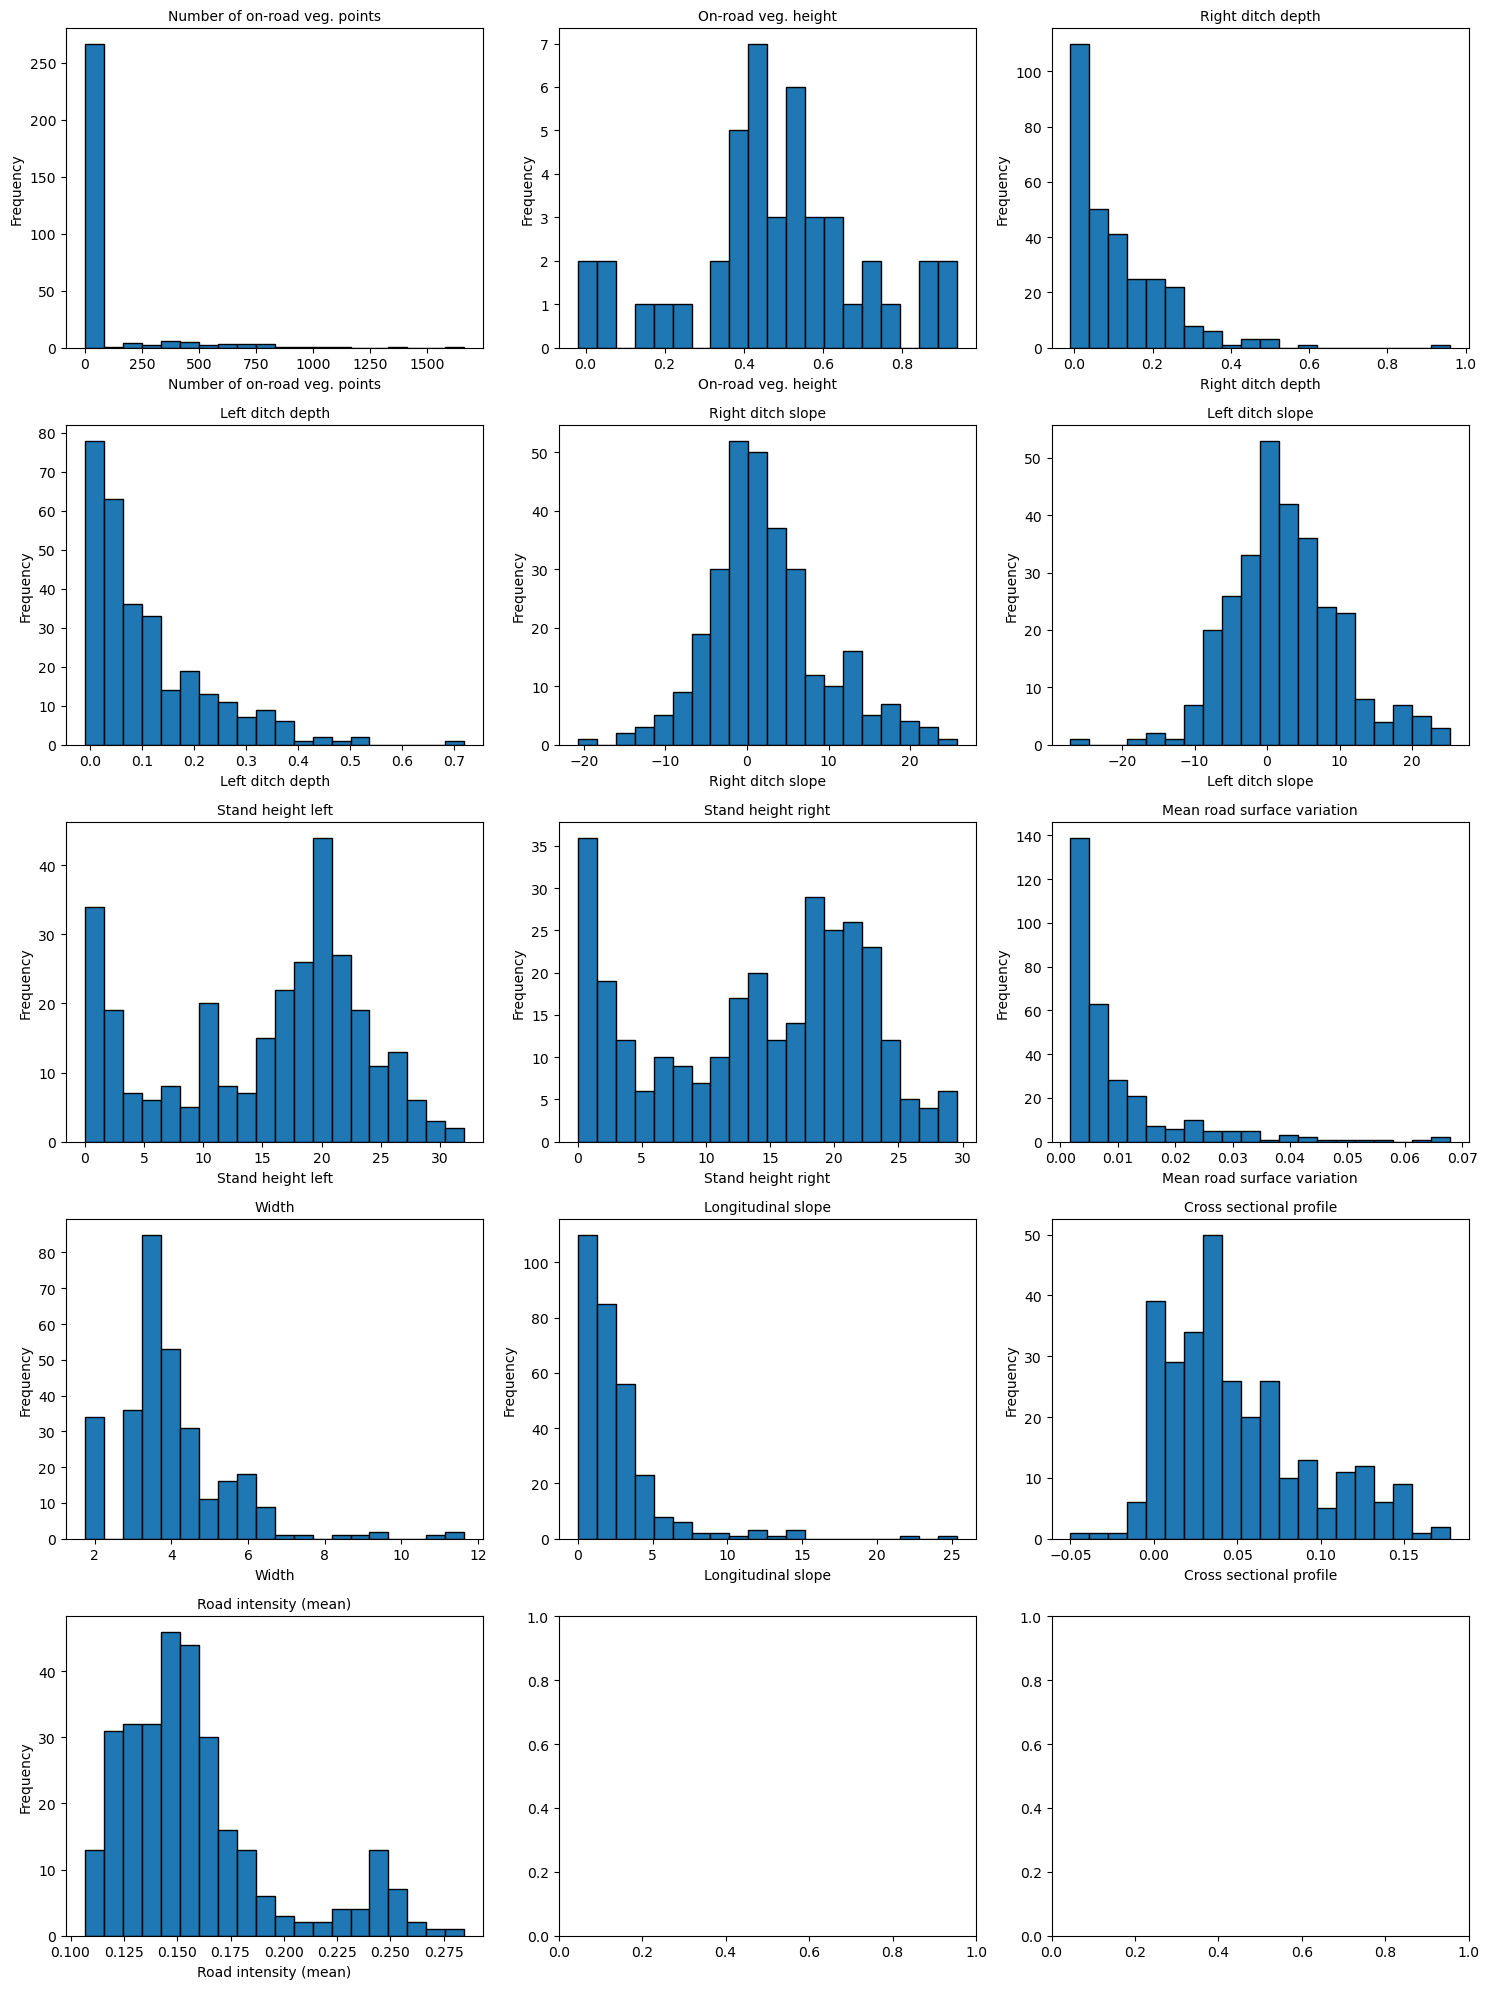

In [ ]:
import os
import matplotlib.pyplot as plt

folder_path = r"C:\Users\telukkari\Documents\Python\forest_road_network_analysis\data\deep_learning_preds\preds_numpy"

buffer_number_of_on_road_veg_points = []
buffer_on_road_veg_height = []
buffer_right_ditch_depth = []
buffer_left_ditch_slope = []
buffer_right_ditch_slope = []
buffer_left_ditch_depth = []
buffer_stand_height_left = []
buffer_stand_height_right = []
buffer_depth_to_water = []
buffer_mean_road_surface_variation = []
buffer_width = []
buffer_slope = []
buffer_cross_sectional_profile = []
buffer_road_intensity = []

for file in os.listdir(folder_path):
    original_points = np.load(os.path.join(folder_path, file))
    # ON-ROAD VEGETATION STATS
    on_road_veg = original_points[original_points[:, flag_col] == 2]
    number_of_on_road_veg_points = on_road_veg.shape[0]
    buffer_number_of_on_road_veg_points.append(number_of_on_road_veg_points)

    top10_idx = np.argsort(on_road_veg[:, 2])[-10:][::-1]
    highest_on_road_veg = on_road_veg[top10_idx]
    median_road_z = np.median(original_points[original_points[:, flag_col] == 0][:, 2])
    on_road_veg_height = np.median(highest_on_road_veg[:, 2]) - median_road_z
    buffer_on_road_veg_height.append(on_road_veg_height)

    # DATA CENTERING
    transformed_points, original_points = mean_center_xy(original_points)

    # ROAD TRIPLET AND DITCH PROFILES
    triplets, mid_points_idxs = fetch_road_triplets(transformed_points, flag_col=flag_col)
    y_bin_edges, x_bin_edges, ditch_profiles = ditch_profiles_from_triplets(
        triplets=triplets, pts=transformed_points, flag_col=flag_col
    )
    right_ditch_depth, left_ditch_depth = compute_ditch_depths(ditch_profiles, triplets)
    buffer_left_ditch_depth.append(left_ditch_depth)
    buffer_right_ditch_depth.append(right_ditch_depth)
    # print(f"Right ditch depth: {right_ditch_depth}, Left ditch depth: {left_ditch_depth}")


    # ABOVE ROAD HIGH VEGETATION STATS
    # high_veg_points_above_road = get_high_veg_points_above_road(triplets, transformed_points)

    stand_height_left, stand_height_right = compute_stand_height(triplets, transformed_points)
    buffer_stand_height_left.append(stand_height_left)
    buffer_stand_height_right.append(stand_height_right)
    # print(f"Stand height left: {stand_height_left}, Stand height right: {stand_height_right}")

    # FETCH DEPTH TO WATER VALUE FROM LUKE MAP
    # middle_point = fetch_middle_point_of_road(triplets)

    # depth_to_water = fetch_depth_to_water_value(middle_point[0], middle_point[1])
    buffer_depth_to_water.append(depth_to_water)
    # print(f"Depth to water: {depth_to_water}")

    # MODEL ROAD AREA SHADINESS BASED ON TREES, ROAD DIRECTION, SUN ANGLE
    shadiness = 0 # TODO

    # FETCH SOIL TYPE FROM SOIL TYPE MAP
    soil_type = 0 # TODO

    # SURFACE VARIATION
    mean_road_surface_variation, std_road_surface_variation = compute_road_surface_roughness(transformed_points)
    buffer_mean_road_surface_variation.append(mean_road_surface_variation)

    middle_point_of_road = fetch_middle_point_of_road(triplets)

    width = compute_width(triplets)
    buffer_width.append(width)
    slope = compute_slope(original_points[mid_points_idxs,:3])
    buffer_slope.append(slope)
    # print(f"Width: {width}, Slope: {slope}")

    cross_sectional_profile, _, _ = compute_cross_sectional_profile(triplets)
    buffer_cross_sectional_profile.append(cross_sectional_profile)
    # print(f"Cross sectional profile: {cross_sectional_profile}")

    road_intensity, std_road_intensity = compute_average_intensity_value_for_road(original_points)
    buffer_road_intensity.append(road_intensity)

    right_ditch_slope, left_ditch_slope = compute_ditch_slopes(ditch_profiles)
    buffer_left_ditch_slope.append(left_ditch_slope)
    buffer_right_ditch_slope.append(right_ditch_slope)


# Put them in a dictionary
data_buffers = {
    "Number of on-road veg. points": buffer_number_of_on_road_veg_points,
    "On-road veg. height": buffer_on_road_veg_height,
    "Right ditch depth": buffer_right_ditch_depth,
    "Left ditch depth": buffer_left_ditch_depth,
    "Right ditch slope": buffer_right_ditch_slope,
    "Left ditch slope": buffer_left_ditch_slope,
    "Stand height left": buffer_stand_height_left,
    "Stand height right": buffer_stand_height_right,
    "Mean road surface variation": buffer_mean_road_surface_variation,
    "Width": buffer_width,
    "Longitudinal slope": buffer_slope,
    "Cross sectional profile": buffer_cross_sectional_profile,
    "Road intensity (mean)": buffer_road_intensity
}

n = len(data_buffers)
cols = 3
rows = (n + cols - 1) // cols  

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
axes = axes.flatten()  

for i, (name, values) in enumerate(data_buffers.items()):
    if len(values) > 0:  
        axes[i].hist(values, bins=20, edgecolor="black")
    axes[i].set_title(name, fontsize=10)
    axes[i].set_xlabel(name)
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()